In [1]:
! lamin load jkobject/scprint

→ connected lamindb: jkobject/scprint


In [1]:
import scanpy as sc

from scprint import scPrint

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd
from anndata import AnnData
import matplotlib.pyplot as plt
import scipy.sparse
from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


→ connected lamindb: jkobject/scprint2


## Loading the data

In [2]:
! mkdir -p data/temp
! wget  https://www.ncbi.nlm.nih.gov/geo/download/\?acc=GSE218566\&format=file
! mv index.html\?acc=GSE218566\&format=file data/temp/GSE218566.tar
! cd data/temp && tar xf GSE218566.tar

In [ ]:
# Read the count matrix, genes and barcodes
adata_whole = sc.read_mtx('data/temp/GSM6752591_on_target_whole_tx_count_matrix.mtx.gz')
genes = pd.read_csv('data/temp/GSM6752591_on_target_whole_tx.Genes.tsv.gz', sep='\t', header=None)
barcodes = pd.read_csv('data/temp/GSM6752591_on_target_whole_tx.Barcodes.tsv.gz', sep='\t', header=None)
adata_whole = adata_whole.T
# Set var names and obs names
adata_whole.var_names = genes[0]
adata_whole.obs_names = barcodes[0]

In [16]:
#read metadata
metadata = pd.read_csv('data/temp/GSM6752591_on_target_cell_metadata.csv.gz', index_col=0)
adata_whole.obs = metadata.loc[adata_whole.obs_names]

In [19]:
# Read sgRNA data
adata_sg = sc.read_mtx('data/temp/GSM6752591_on_target_sgRNA_count_matrix.mtx.gz')
sg_genes = pd.read_csv('data/temp/GSM6752591_on_target_sgRNA.Genes.tsv.gz', sep='\t', header=None)
sg_barcodes = pd.read_csv('data/temp/GSM6752591_on_target_sgRNA.Barcodes.tsv.gz', sep='\t', header=None)

adata_sg = adata_sg.T
# Set var names and obs names for sgRNA data
adata_sg.var_names = sg_genes[0]
adata_sg.obs_names = sg_barcodes[0]

In [31]:
# Set var names and obs names for sgRNA data
adata_sg.var_names = sg_genes[0]
adata_sg.obs_names = sg_barcodes[0]

In [42]:
# Extract base gene names without _NUM suffix
base_genes = [x.rsplit('_', 1)[0] for x in adata_sg.var_names]

# Create mapping dictionary from original column names to base genes
col_mapping = {col: base for col, base in zip(adata_sg.var_names, base_genes)}

# Convert to pandas DataFrame for easier manipulation
sg_df = pd.DataFrame(adata_sg.X.toarray(), columns=adata_sg.var_names, index=adata_sg.obs_names)

# Group by base gene name and sum
sg_df_merged = sg_df.groupby(col_mapping, axis=1).sum()

# Create new AnnData object with merged data
adata_sg_merged = sc.AnnData(sg_df_merged)
adata_sg = adata_sg_merged.to_df()


/local/scratch/tmp/ipykernel_2807153/1882302627.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sg_df_merged = sg_df.groupby(col_mapping, axis=1).sum()


In [51]:
adata_whole.obs[adata_sg.columns] = adata_sg

/local/scratch/tmp/ipykernel_2807153/3158957672.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_whole.obs[adata_sg.columns] = adata_sg
/local/scratch/tmp/ipykernel_2807153/3158957672.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_whole.obs[adata_sg.columns] = adata_sg
/local/scratch/tmp/ipykernel_2807153/3158957672.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [52]:
# Read nascent transcription data
adata_nascent = sc.read_mtx('data/temp/GSM6752591_on_target_nascent_tx_count_matrix.mtx.gz')
nascent_genes = pd.read_csv('data/temp/GSM6752591_on_target_nascent_tx.Genes.tsv.gz', sep='\t', header=None)
nascent_barcodes = pd.read_csv('data/temp/GSM6752591_on_target_nascent_tx.Barcodes.tsv.gz', sep='\t', header=None)

In [53]:
adata_nascent = adata_nascent.T
# Set var names and obs names for nascent data
adata_nascent.var_names = nascent_genes[0]
adata_nascent.obs_names = nascent_barcodes[0]

In [54]:
# Add nascent data as a layer to main object
adata_whole.layers['new'] = adata_nascent[adata_whole.obs_names].X

adata_whole.write_h5ad('data/temp/GSE218566.h5ad')

In [5]:
! mv data/temp/* /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/

mv: cannot stat 'data/temp/': No such file or directory


### https://www.biorxiv.org/content/10.1101/2023.01.29.526143v2.full


In [2]:
adata = sc.read_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/GSE218566.h5ad')

In [8]:
adata.layers['new'].sum(1)

matrix([[ 169.],
        [ 845.],
        [ 442.],
        ...,
        [ 372.],
        [ 327.],
        [1417.]], dtype=float32)

In [7]:
adata.X.sum(1)

matrix([[1179.],
        [4325.],
        [2266.],
        ...,
        [2112.],
        [2467.],
        [8119.]], dtype=float32)

In [24]:
# how many cells have just one gene being KO 
((adata.obs.iloc[:,11:]>0).sum(1)==1).sum()

18541

In [14]:
(adata.obs['NO-TARGET'] == adata.obs['gRNA_UMI_counts']).sum()

556

In [3]:
from scdataloader.utils import load_genes

genes = load_genes("NCBITaxon:9606")

In [4]:
names = adata.var_names[~adata.var_names.str.startswith("ENSG")]
len(names)

58731

In [6]:
rm = set(names) - set(genes.symbol)
len(rm)

19767

In [7]:
torn = list(set(names) & set(genes.symbol))
rnd = {x:y for x,y in zip(torn, genes[genes.symbol.isin(torn)].index.tolist())}
len(rnd)

38964

In [12]:
adata.var_names = pd.Index([rnd.get(x, x) for x in adata.var_names])
adata = adata[:, ~adata.var_names.isin(rm)]


In [21]:
adata

AnnData object with n_obs × n_vars = 98315 × 39662
    obs: 'UMI_counts', 'nascent_UMI_counts', 'nascent_ratio', 'target', 'target_genes', 'gRNA_UMI_counts', 'MT_ratio', 'nascent_MT_ratio', 'Cell_cycle_phase', 'whole_exon_ratio', 'new_exon_ratio', 'ACLY', 'ACO2', 'AGO2', 'ALDOA', 'ALYREF', 'ARID1A', 'ARID1B', 'ARID2', 'ATP11A', 'ATP12A', 'ATP6V1A', 'ATP6V1B2', 'BCS1L', 'BRD4', 'BRD7', 'CASC3', 'CCNH', 'CCT3', 'CCT4', 'CCT8', 'CHD1', 'CLP1', 'CMPK1', 'CNOT1', 'CNOT2', 'CNOT3', 'COX6B1', 'CPSF1', 'CPSF2', 'CPSF3', 'CPSF6', 'CREBBP', 'CS', 'CSTF3', 'CTCF', 'CYC1', 'DDX19B', 'DDX39B', 'DDX56', 'DERL2', 'DHX15', 'DHX29', 'DICER1', 'DIS3', 'DLAT', 'DLD', 'DLST', 'DNMT1', 'DNMT3A', 'DROSHA', 'EEF1D', 'EEF1G', 'EIF2B4', 'EIF2B5', 'EIF2S1', 'EIF2S3', 'EIF3B', 'EMG1', 'ENO2', 'EP300', 'ERCC2', 'ERCC3', 'ETF1', 'EXOSC2', 'EXOSC4', 'EXOSC5', 'EXOSC6', 'FBL', 'FH', 'FOS', 'FOXK1', 'GAPDH', 'GSPT1', 'GTF2A1', 'GTF2A2', 'GTF2E1', 'GTF2H1', 'GTF2H3', 'GTF2H4', 'HDAC1', 'HDAC2', 'HEATR1', 'HNRNPK', 'ID

In [22]:
# Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=4000)
subadata = adata[:, adata.var.highly_variable]

# Run UMAP
sc.pp.neighbors(subadata, n_neighbors=5, n_pcs=50)
sc.tl.umap(subadata, min_dist=0.1, spread=1)


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
subadata.obs['target_genes']

220824perturbsci_06.GCCGACGATACTTGCGCCGC     PRIM1
220824perturbsci_01.CGGACTGGCCTGGTCAGCCA      SDHC
220824perturbsci_07.GTAGTAGTCCACGCGAGATT     SEC62
220824perturbsci_01.AGCTCATTCGGGCAGGTATT      ENO2
220824perturbsci_04.GGCAGCAGTTGCGTTGGAGC      DLAT
                                             ...  
221010perturbsci_09.GAATCTTAGGACCGCCAACC      SMC3
221010perturbsci_12.AACTGACCGGGAAGATCGAG      DLAT
221010perturbsci_13.AAGGTAACCGACTTAACCTT    SEC61G
221010perturbsci_15.CCGATATAAGGCTGGAACTT     CMPK1
221010perturbsci_09.AACTGACCGGAATCCATCTT      OGDH
Name: target_genes, Length: 98315, dtype: category
Categories (204, object): ['ACLY', 'ACO2', 'AGO2', 'ALDOA', ..., 'XPO5', 'XRN2', 'YY1', 'ZC3H13']

In [28]:
subadata.obs['AGO2_KO'] = subadata.obs['target_genes'] == 'AGO2'

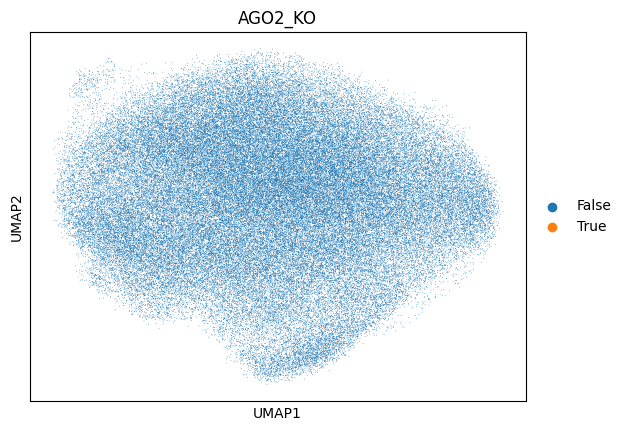

In [29]:
sc.pl.umap(subadata, color='AGO2_KO')

In [31]:
adata.write_h5ad('data/temp/GSE218566.h5ad')

In [3]:
adata = sc.read_h5ad('data/temp/GSE218566.h5ad')
adata

AnnData object with n_obs × n_vars = 98315 × 39662
    obs: 'UMI_counts', 'nascent_UMI_counts', 'nascent_ratio', 'target', 'target_genes', 'gRNA_UMI_counts', 'MT_ratio', 'nascent_MT_ratio', 'Cell_cycle_phase', 'whole_exon_ratio', 'new_exon_ratio', 'ACLY', 'ACO2', 'AGO2', 'ALDOA', 'ALYREF', 'ARID1A', 'ARID1B', 'ARID2', 'ATP11A', 'ATP12A', 'ATP6V1A', 'ATP6V1B2', 'BCS1L', 'BRD4', 'BRD7', 'CASC3', 'CCNH', 'CCT3', 'CCT4', 'CCT8', 'CHD1', 'CLP1', 'CMPK1', 'CNOT1', 'CNOT2', 'CNOT3', 'COX6B1', 'CPSF1', 'CPSF2', 'CPSF3', 'CPSF6', 'CREBBP', 'CS', 'CSTF3', 'CTCF', 'CYC1', 'DDX19B', 'DDX39B', 'DDX56', 'DERL2', 'DHX15', 'DHX29', 'DICER1', 'DIS3', 'DLAT', 'DLD', 'DLST', 'DNMT1', 'DNMT3A', 'DROSHA', 'EEF1D', 'EEF1G', 'EIF2B4', 'EIF2B5', 'EIF2S1', 'EIF2S3', 'EIF3B', 'EMG1', 'ENO2', 'EP300', 'ERCC2', 'ERCC3', 'ETF1', 'EXOSC2', 'EXOSC4', 'EXOSC5', 'EXOSC6', 'FBL', 'FH', 'FOS', 'FOXK1', 'GAPDH', 'GSPT1', 'GTF2A1', 'GTF2A2', 'GTF2E1', 'GTF2H1', 'GTF2H3', 'GTF2H4', 'HDAC1', 'HDAC2', 'HEATR1', 'HNRNPK', 'ID

In [6]:
# Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4, layer='new')
sc.pp.log1p(adata, layer='new')
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000, layer='new')
subadata = adata[:, adata.var.highly_variable]

# Run UMAP
sc.pp.pca(subadata, n_comps=30, layer='new')
sc.pp.neighbors(subadata, n_neighbors=8, use_rep='X_pca')
sc.tl.umap(subadata, min_dist=0.1, spread=1)

/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [7]:
subadata.obs['SMC3_KO'] = subadata.obs['target_genes'] == 'SMC3'

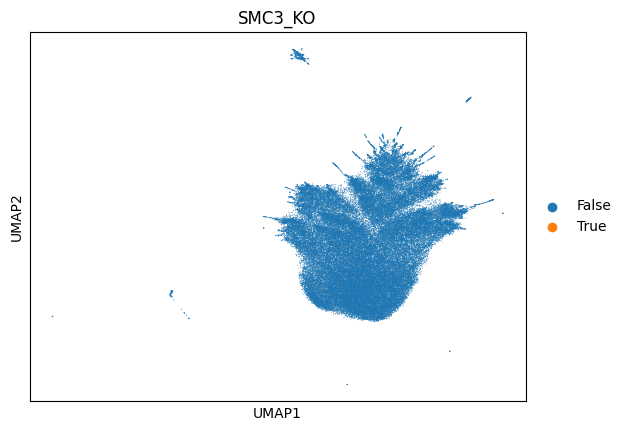

In [8]:
sc.pl.umap(subadata, color='SMC3_KO')

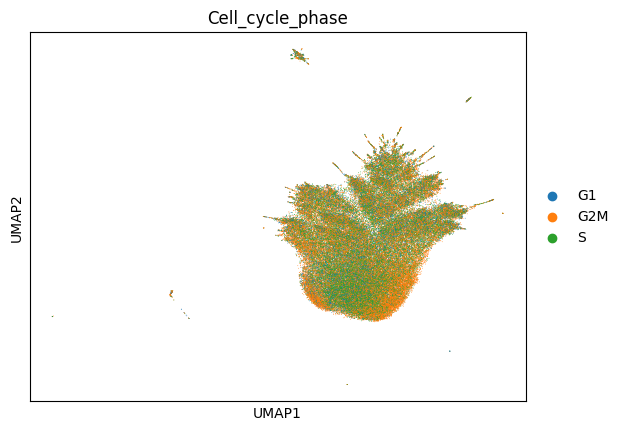

In [48]:
sc.pl.umap(subadata, color='Cell_cycle_phase')

## loading the data 2

In [1]:
! mkdir -p data/temp
! wget  https://www.ncbi.nlm.nih.gov/geo/download/\?acc=GSE131351\&format=file
! mv index.html\?acc=GSE131351\&format=file data/temp/GSE131351.tar
! cd data/temp && tar xf GSE131351.tar

--2025-01-20 13:41:28--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE131351&format=file
Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 314961920 (300M) [application/x-tar]
Saving to: ‘index.html?acc=GSE131351&format=file’

index.html?acc=GSE1 100%[===================>] 300.37M  18.0MB/s    in 29s     

2025-01-20 13:41:58 (10.4 MB/s) - ‘index.html?acc=GSE131351&format=file’ saved [314961920/314961920]



In [8]:
ls data/temp/

GSE131351.tar
GSE218566.h5ad
GSM3770929_HEK293T_3T3_cell_annotate_newly_synthesised.txt.gz
GSM3770929_HEK293T_3T3_cell_annotate.txt.gz
GSM3770929_HEK293T_3T3_gene_annotate_newly_synthesised.txt.gz
GSM3770929_HEK293T_3T3_gene_annotate.txt.gz
GSM3770929_HEK293T_3T3_gene_count_newly_synthesised.txt.gz
GSM3770929_HEK293T_3T3_gene_count.txt.gz
GSM3770930_A549_cell_annotate_newly_synthesised.txt.gz
GSM3770930_A549_cell_annotate.txt.gz
GSM3770930_A549_gene_annotate_newly_synthesised.txt.gz
GSM3770930_A549_gene_annotate.txt.gz
GSM3770930_A549_gene_count_newly_synthesised.txt.gz
GSM3770930_A549_gene_count.txt.gz


In [12]:
# Read the cell annotation files
cell_df = pd.read_csv('data/temp/GSM3770930_A549_cell_annotate.txt.gz', delimiter=',')
cell_df_new = pd.read_csv('data/temp/GSM3770930_A549_cell_annotate_newly_synthesised.txt.gz', delimiter=',')

# Read the gene annotation files 
gene_df = pd.read_csv('data/temp/GSM3770930_A549_gene_annotate.txt.gz', delimiter=',')
gene_df_new = pd.read_csv('data/temp/GSM3770930_A549_gene_annotate_newly_synthesised.txt.gz', delimiter=',')

# Read the count matrices
count_df = pd.read_csv('data/temp/GSM3770930_A549_gene_count.txt.gz', delimiter=' ')
count_df_new = pd.read_csv('data/temp/GSM3770930_A549_gene_count_newly_synthesised.txt.gz', delimiter=' ')


NameError: name 'anndata' is not defined

In [47]:
adata.X[7403, 43166] = 0
adata.layers['new'][7403, 43166] = 0

In [ ]:
# Create AnnData object with total counts
data = np.asarray(count_df['coordinate'])
row_ind= np.asarray(count_df['matrix'])-1 # so it starts at 0 not 1
col_ind =  np.asarray(count_df['%%MatrixMarket'])-1
shape = (7404,43167)
count_matrix =scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape)


adata = AnnData(
    X=count_matrix,
    obs=cell_df,
    var=gene_df
)

data = np.asarray(count_df_new['coordinate'])
row_ind= np.asarray(count_df_new['matrix'])-1 # so it starts at 0 not 1
col_ind =  np.asarray(count_df_new['%%MatrixMarket'])-1
shape = (7404,43167)
adata.layers['new'] = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape)

# Add newly synthesized counts as a layer
adata.layers['new'] = scipy.sparse.csr_matrix(count_df_new.values)

# Display the AnnData object
adata

In [33]:
adata.obs.index = adata.obs['sample']
adata.obs.drop(columns=['sample'], inplace=True)
adata.var.index = adata.var['gene_id']
adata.var.drop(columns=['gene_id'], inplace=True)

In [48]:
adata.write_h5ad('data/temp/GSE131351.h5ad')

... storing 'gene_short_name' as categorical


In [35]:
(adata.X>0).sum(1)

matrix([[7948],
        [7071],
        [5661],
        ...,
        [7069],
        [6516],
        [5549]])

In [44]:
((adata.X>0).todense() | (adata.layers['new']>0).todense()).sum(1)

matrix([[7948],
        [7071],
        [5661],
        ...,
        [7069],
        [6516],
        [5549]])

In [50]:
adata

AnnData object with n_obs × n_vars = 7404 × 43167
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score'
    var: 'gene_type', 'gene_short_name'
    layers: 'new'

In [54]:
# Calculate correlation between X and new layer for each cell
cell_corrs = []
for i in range(adata.n_obs):
    x = adata.X[i].toarray().flatten()
    new = adata.layers['new'][i].toarray().flatten()
    corr = np.corrcoef(x, new)[0,1]
    cell_corrs.append(corr)

# Calculate mean X across cells
mean_x = np.array(adata.X.mean(axis=0)).flatten()

# Calculate correlation of each cell's X with mean X
mean_corrs = []
for i in range(adata.n_obs):
    x = adata.X[i].toarray().flatten()
    corr = np.corrcoef(x, mean_x)[0,1]
    mean_corrs.append(corr)

print(f"Average X vs new correlation: {np.mean(cell_corrs):.3f}")
print(f"Average X vs mean X correlation: {np.mean(mean_corrs):.3f}")

Average X vs new correlation: 0.576
Average X vs mean X correlation: 0.887


In [56]:
mean_x = np.array(adata.layers['new'].mean(axis=0)).flatten()

# Calculate correlation of each cell's X with mean X
mean_corrs = []
for i in range(adata.n_obs):
    x = adata.layers['new'][i].toarray().flatten()
    corr = np.corrcoef(x, mean_x)[0,1]
    mean_corrs.append(corr)
print(f"Average new vs mean new correlation: {np.mean(mean_corrs):.3f}")

Average new vs mean new correlation: 0.658


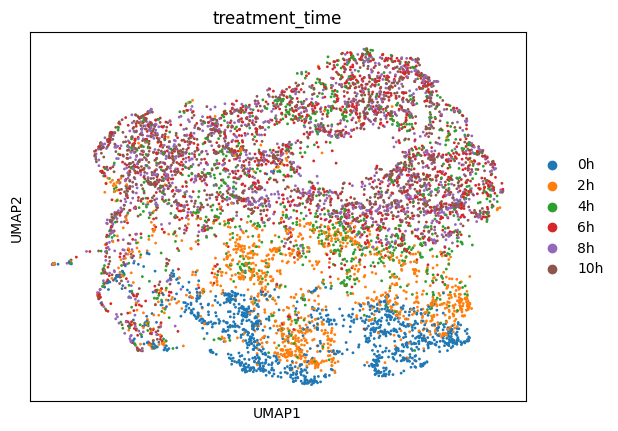

In [57]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
subadata = adata[:, adata.var.highly_variable]

# Run UMAP
sc.pp.pca(subadata, n_comps=30)
sc.pp.neighbors(subadata, n_neighbors=8, use_rep='X_pca')
sc.tl.umap(subadata, min_dist=0.1, spread=1)
sc.pl.umap(subadata, color='treatment_time')

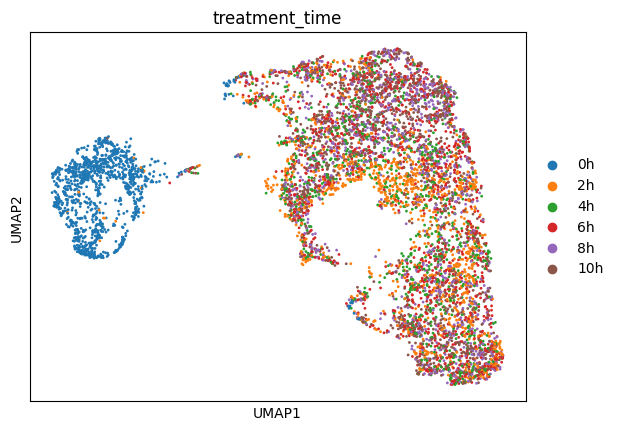

In [55]:
sc.pp.normalize_total(adata, target_sum=1e4, layer='new')
sc.pp.log1p(adata, layer='new')
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000, layer='new')
subadata = adata[:, adata.var.highly_variable]

# Run UMAP
sc.pp.pca(subadata, n_comps=30, layer='new')
sc.pp.neighbors(subadata, n_neighbors=8, use_rep='X_pca')
sc.tl.umap(subadata, min_dist=0.1, spread=1)
sc.pl.umap(subadata, color='treatment_time')


In [60]:
adata.var.index = adata.var.index.str.split('.').str[0]
adata.var.index.duplicated().sum()

0

In [61]:
adata.var.index

Index(['ENSG00000227232', 'ENSG00000238009', 'ENSG00000233750',
       'ENSG00000237683', 'ENSG00000241860', 'ENSG00000228463',
       'ENSG00000241670', 'ENSG00000237094', 'ENSG00000233653',
       'ENSG00000236601',
       ...
       'ENSG00000242716', 'ENSG00000266658', 'ENSG00000243151',
       'ENSG00000265807', 'ENSG00000265525', 'ENSG00000241335',
       'ENSG00000265830', 'ENSG00000233094', 'ENSG00000218497',
       'ENSG00000229631'],
      dtype='object', name='gene_id', length=43167)

## loading the data 3

In [ ]:
! mkdir -p data/temp
! wget  https://www.ncbi.nlm.nih.gov/geo/download/\?acc=GSE202292\&format=file
! mv index.html\?acc=GSE202292\&format=file data/temp/GSE202292.tar
! cd data/temp && tar xf GSE202292.tar

## preparing the model

In [63]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
preprocessor = Preprocessor(keepdata=True,is_symbol=False, force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: new)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 7404 renamining
filtered out 0 cells, 7404 renamining
Removed 2674 genes.
startin QC
Seeing 176 outliers (2.38% of total dataset):
done
AnnData object with n_obs × n_vars = 7404 × 70116
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_type', 'gene_short_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'uid', 'symbol', 'ncbi_gene_ids', 'bioty

AnnData object with n_obs × n_vars = 7404 × 70116
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_type', 'gene_short_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'
    layers: 'new'

In [66]:
model = scPrint.load_from_checkpoint(
    #'../../7asy8qpn.ckpt', 
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', 
    precpt_gene_emb=None)


changing the number of classes, could lead to issues
RuntimeError caught: scPrint is not attached to a `Trainer`.


In [67]:
model

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(44756, 512)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(7, 512)
  )
  (depth_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (transformer): FlashTransformer(
    (blocks): ModuleList(
      (0): Block(
        (mixer): MHA(
          (Wqkv): Linear(in_features=51

# good dataset

In [4]:
embed = Embedder(how="random expr", max_len=4000, add_zero_genes=0, num_workers=16, pred_embedding = ["cell_type_ontology_term_id"], keep_all_cls_pred=False, output_expression="none")

In [38]:
fine = {"gamma": "CL:0002275",
"beta": "CL:0000169", # "CL:0008024"
"epsilon": "CL:0005019", # "CL:0008024"
"acinar": "CL:0000622",
'delta': 'CL:0000173', #"CL:0008024"
'schwann': 'CL:0002573', # "CL:0000125"
'activated_stellate': 'CL:0000057',
'alpha': 'CL:0000171',# "CL:0008024"
'mast': 'CL:0000097',
'Mast cell': 'CL:0000097',
'quiescent_stellate': 'CL:0000057',
't_cell': 'CL:0000084',
'endothelial': 'CL:0000115',
'Endothelium': 'CL:0000115',
'ductal': 'CL:0002079', #CL:0000068
'macrophage': 'CL:0000235',
'Macrophage': 'CL:0000235',
'B cell': 'CL:0000236',
'Type 2': 'CL:0002063',
'Type 1': 'CL:0002062',
'Ciliated': 'CL:4030034', # respiratory ciliated
'Dendritic cell': 'CL:0000451', #leukocyte
'Secretory': 'CL:0000151',
'Ionocytes': 'CL:0005006',
'Basal 1': 'CL:0000646', # epithelial
'Basal 2': 'CL:0000646',
'Neutrophil_CD14_high': 'CL:0000775',
'Neutrophils_IL1R2': 'CL:0000775',
'Lymphatic': 'CL:0002138',
'Fibroblast': 'CL:0000057',
'T/NK cell': 'CL:0000814',

'inDrop1': 'EFO:0008780',
'inDrop3': 'EFO:0008780',
'inDrop4': 'EFO:0008780',
'inDrop2': 'EFO:0008780',
'fluidigmc1': 'EFO:0010058', #fluidigm c1
'smarter': 'EFO:0010058', #fluidigm c1
'celseq2': 'EFO:0010010',
'smartseq2': 'EFO:0008931',
'celseq': 'EFO:0008679',
}
coarse = {
"beta": "CL:0008024", #endocrine
"epsilon": "CL:0008024",
'delta': "CL:0008024",
'alpha': "CL:0008024",
"gamma": "CL:0008024",
"acinar": "CL:0000150", #epithelial (gland)
'ductal': "CL:0000068", #epithelial (duct)
'schwann': "CL:0000125", # glial
'endothelial': 'CL:0000115',
'Endothelium': 'CL:0000115',
'Lymphatic': 'CL:0000115',
'macrophage': 'CL:0000235', #myeloid leukocyte (not) 
'Macrophage': 'CL:0000235', # myeloid leukocyte
'mast': 'CL:0000097', #myeloid leukocyte (not)
'Mast cell': 'CL:0000097', #myeloid leukocyte
'Neutrophil_CD14_high': 'CL:0000775', #myeloid leukocyte
'Neutrophils_IL1R2': 'CL:0000775', #myeloid leukocyte
't_cell': 'CL:0000084', #leukocyte, lymphocyte (not)
'T/NK cell': 'CL:0000084', #leukocyte, lymphocyte (not)
'B cell': 'CL:0000236', #leukocyte, lymphocyte (not)
'Dendritic cell': 'CL:0000451', #leukocyte, lymphocyte
'activated_stellate': 'CL:0000057', # fibroblast (not)
'quiescent_stellate': 'CL:0000057', # fibroblast (not)
'Fibroblast': 'CL:0000057',
'Type 2': 'CL:0000066', # epithelial
'Type 1': 'CL:0000066',
'Ionocytes': 'CL:0000066', # epithelial
'Basal 1': 'CL:0000066', # epithelial
'Basal 2': 'CL:0000066',
'Ciliated': 'CL:0000064', # ciliated
'Secretory': 'CL:0000151',

'inDrop1': 'EFO:0008780',
'inDrop3': 'EFO:0008780',
'inDrop4': 'EFO:0008780',
'inDrop2': 'EFO:0008780',
'fluidigmc1': 'EFO:0010058', #fluidigm c1
'smarter': 'EFO:0010058', #fluidigm c1
'celseq2': 'EFO:0010010',
'smartseq2': 'EFO:0008931',
'celseq': 'EFO:0008679',
}


In [39]:
n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(fine) #fine, coarse
#n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(coarse)

/tmp/ipykernel_1176997/2747151874.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  n_adata.obs['cell_type_ontology_term_id'] = n_adata.obs['celltype'].replace(fine) #fine, coarse
